In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_celeba_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/Heteroskedastic_CelebA_Ppc/0528_235930/checkpoint_14.ckpt")

Missing logger folder: saved/log/Heteroskedastic_CelebA_Ppc/0530_160722/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0530_160722 exists and is not empty.
Restoring states from the checkpoint path at saved/models/Heteroskedastic_CelebA_Ppc/0528_235930/checkpoint_14.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0528_235930' to '/workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0530_160722', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type         | Params
--------------------------------------------
0 | graph      | GeneratorPpc | 389 K 
1

Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
`Trainer.fit` stopped: `max_epochs=15` reached.


In [7]:
model.graph.clear()
model.eval()
model.cuda()

LightningPpc(
  (graph): GeneratorPpc(
    (prior): GaussianPrior()
    (likelihood): ConvolutionalDecoder(
      (linear): Sequential(
        (0): Linear(in_features=40, out_features=256, bias=True)
        (1): SiLU()
      )
      (convs): Sequential(
        (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): SiLU()
        (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): SiLU()
        (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (8): SiLU()
        (9): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

In [8]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)
model._load_particles(indices, False)

In [9]:
with model.graph.condition(X=xs) as joint:
    for i in range(299):
        trace, log_weight = joint(B=len(xs), lr=1e-3, P=model.num_particles)
        logger.info("Free energy at evaluation %d: %f" % (i+1, -log_weight.mean()))
        del trace
        del log_weight
    _, log_weight = joint(B=len(xs), lr=1e-3, P=model.num_particles)
logger.info("Free energy at evaluation 300: %f" % -log_weight.mean())
del log_weight

Free energy at evaluation 1: -11581.515625
Free energy at evaluation 2: -11580.991211
Free energy at evaluation 3: -11581.609375
Free energy at evaluation 4: -11581.210938
Free energy at evaluation 5: -11580.645508
Free energy at evaluation 6: -11581.313477
Free energy at evaluation 7: -11581.417969
Free energy at evaluation 8: -11580.279297
Free energy at evaluation 9: -11579.389648
Free energy at evaluation 10: -11578.148438
Free energy at evaluation 11: -11576.531250
Free energy at evaluation 12: -11579.328125
Free energy at evaluation 13: -11575.375000
Free energy at evaluation 14: -11577.011719
Free energy at evaluation 15: -11575.828125
Free energy at evaluation 16: -11578.580078
Free energy at evaluation 17: -11577.692383
Free energy at evaluation 18: -11579.069336
Free energy at evaluation 19: -11577.728516
Free energy at evaluation 20: -11578.073242
Free energy at evaluation 21: -11577.666016
Free energy at evaluation 22: -11578.369141
Free energy at evaluation 23: -11578.3271

In [10]:
with model.graph.condition(z=model.graph.nodes['z']['value']) as predictive:
    x_hats = predictive(B=len(xs), mode="prior", P=model.num_particles).mean(dim=0)

In [11]:
import matplotlib.pyplot as plt

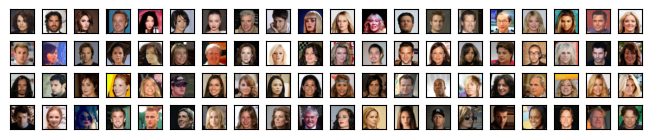

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        orgs = xs[row * 20 + col].detach().transpose(0, -1).cpu()
        axes[row, col].imshow(orgs)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_orgs.pdf", bbox_inches="tight")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

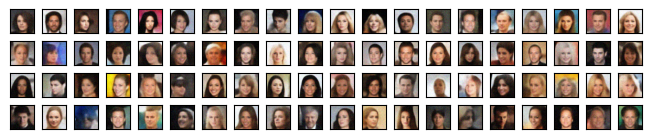

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = x_hats[row * 20 + col].detach().transpose(0, -1).cpu()
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_recons.pdf", bbox_inches="tight")
plt.show()

In [14]:
del xs
del x_hats

In [15]:
model.graph.clear()

In [16]:
model.graph(B=80 // model.num_particles, lr=1e-3, mode="prior", P=model.num_particles)
for _ in range(299):
    model.graph(B=80 // model.num_particles, lr=1e-3, P=model.num_particles)
x_hats = model.graph(B=80 // model.num_particles, lr=1e-3, mode="prior", P=model.num_particles)
x_hats = x_hats.flatten(0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

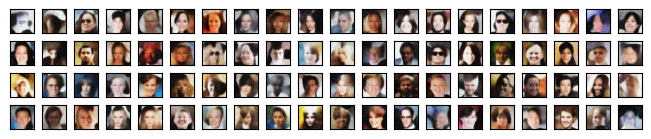

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = x_hats[row * 20 + col].squeeze().detach().transpose(0, -1).cpu()
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_samples.pdf", bbox_inches="tight")
plt.show()

In [18]:
del x_hats

In [19]:
SEEDS = [123, 456, 789, 101112, 131415]

In [20]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [21]:
with torch.no_grad():
    for (s, SEED) in enumerate(SEEDS):
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        for b, (xs, target, indices) in enumerate(data.val_dataloader()):
            xs = xs.to(model.device)
            model._load_particles(indices, False)
            x_hats = model.graph(B=len(xs), mode="prior", P=model.num_particles)
            with model.graph.condition(X=xs) as predictive:
                trace, _ = predictive(B=len(xs), P=model.num_particles)
            LOG_LIKELIHOODS[s] += trace.nodes['X']['fn'].log_prob(xs).sum().cpu()
            MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean().cpu()
    
            del xs
            del x_hats
            del trace
            del target
            del indices
            logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))
    
        LOG_LIKELIHOODS[s] /= len(data.val_dataloader().dataset)
        MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().dataset)

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0
Evaluated likelihood for valid batch 4 under seed 0
Evaluated likelihood for valid batch 5 under seed 0
Evaluated likelihood for valid batch 6 under seed 0
Evaluated likelihood for valid batch 7 under seed 0
Evaluated likelihood for valid batch 8 under seed 0
Evaluated likelihood for valid batch 9 under seed 0
Evaluated likelihood for valid batch 10 under seed 0
Evaluated likelihood for valid batch 11 under seed 0
Evaluated likelihood for valid batch 12 under seed 0
Evaluated likelihood for valid batch 13 under seed 0
Evaluated likelihood for valid batch 14 under seed 0
Evaluated likelihood for valid batch 15 under seed 0
Evaluated likelihood for valid batch 16 under seed 0
Evaluated likelihood for valid batch 17 under seed 0
Evaluated likelihood for valid batch 18 under seed 0
Eva

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluated likelihood for valid batch 0 under seed 1
Evaluated likelihood for valid batch 1 under seed 1
Evaluated likelihood for valid batch 2 under seed 1
Evaluated likelihood for valid batch 3 under seed 1
Evaluated likelihood for valid batch 4 under seed 1
Evaluated likelihood for valid batch 5 under seed 1
Evaluated likelihood for valid batch 6 under seed 1
Evaluated likelihood for valid batch 7 under seed 1
Evaluated likelihood for valid batch 8 under seed 1
Evaluated likelihood for valid batch 9 under seed 1
Evaluated likelihood for valid batch 10 under seed 1
Evaluated likelihood for valid batch 11 under seed 1
Evaluated likelihood for valid batch 12 under seed 1
Evaluated likelihood for valid batch 13 under seed 1
Evaluated likelihood for valid batch 14 under seed 1
Evaluated likelihood for valid batch 15 under seed 1
Evaluated likelihood for valid batch 16 under seed 1
Evaluated likelihood for valid batch 17 under seed 1
Evaluated likelihood for valid batch 18 under seed 1
Eva

In [22]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-6890.9600), tensor(123.7259))

In [23]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0007), tensor(8.6064e-07))

In [24]:
model.graph.clear()

In [25]:
import utils.util as util
import glob

In [26]:
NUM_SAMPLES = 4096
num_samples = len(glob.glob("data/celeba_ppc/*.jpg"))

In [27]:
util.ensure_dir('data/celeba_ppc')

In [28]:
plt.set_loglevel("error")

while num_samples < NUM_SAMPLES:
    x_hats = model.graph(B=data.batch_size, mode="prior", P=model.num_particles).mean(dim=0)
    x_hats = x_hats.detach().transpose(1, -1).cpu()
    for k in range(data.batch_size):
        fig = plt.imshow(x_hats[k].squeeze().numpy())
        plt.savefig("data/celeba_ppc/%d.jpg" % (num_samples + k))
    num_samples += data.batch_size

    logger.info("Generated %d sample images" % num_samples)

In [29]:
x_hats = model.graph(B=data.batch_size, mode="prior", P=model.num_particles).view(data.batch_size * model.num_particles, 3, 64, 64)

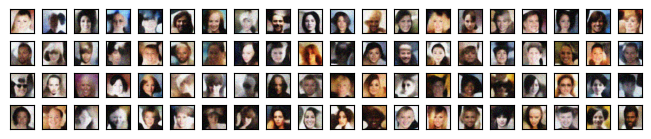

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = x_hats[row * 20 + col].squeeze().detach().transpose(0, -1).cpu()
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.show()